### Convert to format

Example

`vl_finetune_data.json`
```json
[
    {
      "id": "0",
      "image": 'path/to/image_0.jpg',
      "conversations": [
            {
              'role': 'user', 
              'content': '<image>\nHow many desserts are on the white plate?'
            }, 
            {
                'role': 'assistant', 
                'content': 'There are three desserts on the white plate.'
            },   
            {
                'role': 'user', 
                'content': 'What type of desserts are they?'
            },
            {
                'role': 'assistant', 
                'content': 'The desserts are cakes with bananas and pecans on top. They share similarities with donuts, but the presence of bananas and pecans differentiates them.'
            }, 
            {
                'role': 'user', 
                'content': 'What is the setting of the image?'}, 
            {
                'role': 'assistant', 
                'content': 'The image is set on a table top with a plate containing the three desserts.'
            },
        ]
    },
]
```

In [372]:
!rm -r '/opt/share/NRazuvaev/OCR/data_docs/raw/labels'

rm: cannot remove '/opt/share/NRazuvaev/OCR/data_docs/raw/labels': No such file or directory


In [373]:
!unzip -q '/opt/share/NRazuvaev/OCR/data_docs/raw/labels.zip' -d '/opt/share/NRazuvaev/OCR/data_docs/raw/labels'

In [374]:
!unzip -q '/opt/share/NRazuvaev/OCR/data_docs/raw/pdf.zip' -d '/opt/share/NRazuvaev/OCR/data_docs/raw/pdf'

In [443]:
!unzip -q '/opt/share/NRazuvaev/OCR/data_docs/raw/Судебные документы.zip' -d '/opt/share/NRazuvaev/OCR/data_docs/raw/Судебные документы'

In [375]:
# !mkdir test

In [445]:
from pdf2image import convert_from_path
from PIL import Image
from matplotlib import pyplot as plt
import json
import glob
import os
import re
from tqdm.notebook import tqdm
import pandas as pd

In [377]:
label_paths = glob.glob('/opt/share/NRazuvaev/OCR/data_docs/raw/labels/*.json')
doc_names = list(map(lambda x: x.split('_')[-1].split('.')[0], label_paths))

# pdf_paths = glob.glob('/opt/share/NRazuvaev/OCR/data_docs/raw/pdf-5000/*.pdf')
pdf_paths = list(map(lambda x: f'/opt/share/NRazuvaev/OCR/data_docs/raw/pdf/{x}.pdf', doc_names))
save_image_path = '/opt/share/NRazuvaev/OCR/data_docs/train/images'

if not os.path.exists(save_image_path):
    os.mkdir(save_image_path)

for pdf_path in tqdm(pdf_paths):
    
    if os.path.exists(os.path.join(save_image_path, pdf_path.split('/')[-1].split('.')[0] + f'_0000.jpg')):
        continue
    images = convert_from_path(pdf_path)
    
    for i in range(len(images)):
        
        p = os.path.join(save_image_path, pdf_path.split('/')[-1].split('.')[0] + f'_{i:04d}.jpg')
        images[i].save(p, 'JPEG')

  0%|          | 0/2840 [00:00<?, ?it/s]

In [499]:
# Парсинг данных
def parse_dialog(text, idx = None, image_id = None):
    dialog_list = []
    dialog_counter = idx if idx else 0

    # Разделение на отдельные диалоги
    raw_dialogs = info_json['response'].split("### Диалог")

    for raw_dialog in raw_dialogs[1:]:
        dialog_id = str(dialog_counter)
        dialog_counter += 1

        # Инициализация словаря для хранения сообщений
        conversation = {"id": dialog_id, "conversations": []}

        # Разделение диалога на реплики пользователя и ассистента
        dialog_parts = re.split('\n*Пользователь:\n"""|\nПользователь:\n"', raw_dialog) # raw_dialog.split('\nПользователь:\n"""')
        dialog_parts = [re.split('\nАссистент:\n"""|\nАссистент:\n"|\nАссистент:\n', part) for part in dialog_parts] # [part.split('\nАссистент:\n"""') for part in dialog_parts]
        
        for part in dialog_parts:
            if len(part) == 2:
                user_content = part[0].strip('"""').strip()
                conversation["conversations"].append({
                    "role": "user",
                    "content": user_content
                })
                assistant_content = part[1].strip().strip('"""').strip().replace('``````', '```')
                # Попытка распарсить JSON
                # try:
                #     json_content = json.loads(assistant_content)
                #     assistant_content = json.dumps(json_content, ensure_ascii=False, indent=4)
                # except:
                #     pass
                conversation["conversations"].append({
                    "role": "assistant",
                    "content": assistant_content
                })

        dialog_list.append(conversation)
    
    return dialog_list

In [506]:
label_paths = glob.glob('/opt/share/NRazuvaev/OCR/data_docs/raw/labels/*.json')
info = []
idx = 0
a = 0
for i, label_path in enumerate(label_paths):
    with open(label_path, 'r') as f:
        info_json = json.load(f)
    
    dialog_list = parse_dialog(info_json['response'], idx = idx, image_id = None)
    
    for j in dialog_list:
        if len(j['conversations']) <= 1:
            if j['id'] in ('1377', '2504', '3853', '7461'):
                dialog_list = dialog_list[:-1]
            else:
                a = 1
    
    if a == 1:
        break
            
    for dialog in dialog_list:
        dialog['image'] = '/opt1/share/NRazuvaev/OCR/data_docs/train/images/' +\
                           info_json['doc_name'].split('.')[0] + '_{0:04d}.jpg'.format(info_json["page_id"]) 
    
    if info_json['response'] == 'Thank you! How can I assist you today?':
        continue
    elif len(dialog_list) == 0:
        break
    idx = int(dialog_list[-1]['id']) + 1
    info.extend(dialog_list)
    
a

0

In [1]:
info[-1:]

NameError: name 'info' is not defined

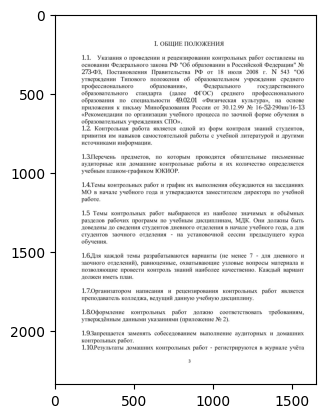

[{'id': '9044',
  'conversations': [{'role': 'user',
    'content': 'Как оформить контрольные работы в соответствии с указанными требованиями?'},
   {'role': 'assistant',
    'content': 'Я не могу предоставить конкретные требования к оформлению, так как это зависит от данных указаний (приложение № 2), которые не предоставлены в контексте изображения. Пожалуйста, уточните дополнительные детали или приложите соответствующий документ.'},
   {'role': 'user',
    'content': 'Кто является организатором написания и рецензирования контрольных работ?'},
   {'role': 'assistant',
    'content': '```json\n{\n    "Организатор": "преподаватель колледжа, ведущий данную учебную дисциплину"\n}\n```'}],
  'image': '/opt1/share/NRazuvaev/OCR/data_docs/train/images/002977_0002.jpg'}]

In [508]:
plt.imshow(Image.open('/opt/share/NRazuvaev/OCR/data_docs/train/images/002977_0002.jpg'))
plt.show()

info[-1:]

In [509]:
with open('/opt/share/NRazuvaev/OCR/data_docs/train/train_finetune_data.json', 'w') as f:
    json.dump(info, f)

In [510]:
dialog_list[0]

{'id': '9042',
 'conversations': [{'role': 'user',
   'content': 'Какой федеральный закон является основой для указаний о проведении и рецензировании контрольных работ?'},
  {'role': 'assistant',
   'content': '```json\n{\n    "Федеральный закон": {\n        "Номер": "273-ФЗ",\n        "Дата": "29 декабря 2012 года",\n        "Название": "Об образовании в Российской Федерации"\n    }\n}\n```'},
  {'role': 'user',
   'content': 'Каким постановлением утверждено Типовое положение об образовательном учреждении среднего профессионального образования?'},
  {'role': 'assistant',
   'content': '```json\n{\n    "Постановление": {\n        "Номер": "543",\n        "Дата": "18 июля 2008 года",\n        "Название": "Об утверждении Типового положения об образовательном учреждении среднего профессионального образования"\n    }\n}\n```'}],
 'image': '/opt1/share/NRazuvaev/OCR/data_docs/train/images/002977_0002.jpg'}

In [511]:
# info = []
labels_real = pd.read_excel('/opt/share/NRazuvaev/OCR/data_docs/raw/Судебные документы/Судебный приказ/labels.xlsx')

idx = int(info[-1]['id']) + 1
# idx = 0

for row_id, row in labels_real.iterrows():
    im_name = row["image_name"]
    if im_name == '020.png':
        im_name = '020.jpeg'
    if im_name == '028.jpg':
        im_name = '028.png'
    if im_name == '025.png':
        im_name = '025.jpg'
    dialog_list = [{
        'id': str(idx),
        'conversations': [
            {'role': 'user', 'content': row['prompt']},
            {'role': 'assistant', 'content': row['response']},
        ],
        'image': f'/opt1/share/NRazuvaev/OCR/data_docs/raw/Судебные документы/Судебный приказ/{im_name}',
    }]
    
    idx += 1
    
    info.extend(dialog_list)

In [512]:
info[-1]['id']

'9094'

In [513]:
with open('/opt/share/NRazuvaev/OCR/data_docs/train/train_finetune_data.json', 'w') as f:
    json.dump(info, f)

In [514]:
info[0]

{'id': '0',
 'conversations': [{'role': 'user',
   'content': 'Можешь описать, что говорится в пункте 8.3 документа?'},
  {'role': 'assistant',
   'content': "```json\n{\n    'Пункт 8.3': 'Стороны настоящим соглашаются, что следующие события не являются Обстоятельствами непреодолимой силы (форс-мажором): 1) неосторожное или намеренное действие, ошибки, бездействие, несоблюдение законодательства или нарушение Договора, или неисполнение обязательств по Договору, допущенные Стороной; 2) забастовки, снижение темпа работы, которые затрагивают только сотрудников Стороны или какого-либо субподрядчика Стороны; 3) сложная экономическая ситуация или изменение рыночных условий.'\n}\n```"},
  {'role': 'user', 'content': 'Что сказано о природных катастрофах?'},
  {'role': 'assistant',
   'content': "```json\n{\n    'Природные катастрофы': 'Природные катастрофы, такие как землетрясение, ураган, наводнение, оползни, техногенные и экологические бедствия, природные разрушительные явления и катаклизмы, 